## 4차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [3]:
ticker = '005930.KS' # 삼성전자 주식 불러오기
stock_data = yf.download(ticker, start="2020-01-01", end="2024-10-04")
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2020-01-02  55500.0  56000.0  55000.0  55200.0  49099.429688  12993228
2020-01-03  56000.0  56600.0  54900.0  55500.0  49366.273438  15422255
2020-01-06  54900.0  55600.0  54600.0  55500.0  49366.273438  10278951
2020-01-07  55700.0  56400.0  55600.0  55800.0  49633.113281  10009778
2020-01-08  56200.0  57400.0  55900.0  56800.0  50522.601562  23501171


In [ ]:
stock_data.to_csv('/content/gdrive/MyDrive/DAT/4기 과제/4차 과제/samsung_stock_data.csv')

In [4]:
df = pd.read_csv("/content/gdrive/MyDrive/DAT/4기 과제/4차 과제/samsung_stock_data.csv")
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,55500.0,56000.0,55000.0,55200.0,49099.425781,12993228
1,2020-01-03,56000.0,56600.0,54900.0,55500.0,49366.261719,15422255
2,2020-01-06,54900.0,55600.0,54600.0,55500.0,49366.261719,10278951
3,2020-01-07,55700.0,56400.0,55600.0,55800.0,49633.109375,10009778
4,2020-01-08,56200.0,57400.0,55900.0,56800.0,50522.589844,23501171
5,2020-01-09,58400.0,58600.0,57400.0,58600.0,52123.667969,24102579
6,2020-01-10,58800.0,59700.0,58300.0,59500.0,52924.191406,16000170
7,2020-01-13,59600.0,60000.0,59100.0,60000.0,53368.941406,11359139
8,2020-01-14,60400.0,61000.0,59900.0,60000.0,53368.941406,16906295
9,2020-01-15,59500.0,59600.0,58900.0,59000.0,52479.453125,14300928


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [5]:
missing_values = df.isnull().sum()
print(missing_values)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,55500.0,56000.0,55000.0,55200.0,49099.425781,12993228
2020-01-03,56000.0,56600.0,54900.0,55500.0,49366.261719,15422255
2020-01-06,54900.0,55600.0,54600.0,55500.0,49366.261719,10278951
2020-01-07,55700.0,56400.0,55600.0,55800.0,49633.109375,10009778
2020-01-08,56200.0,57400.0,55900.0,56800.0,50522.589844,23501171
2020-01-09,58400.0,58600.0,57400.0,58600.0,52123.667969,24102579
2020-01-10,58800.0,59700.0,58300.0,59500.0,52924.191406,16000170
2020-01-13,59600.0,60000.0,59100.0,60000.0,53368.941406,11359139
2020-01-14,60400.0,61000.0,59900.0,60000.0,53368.941406,16906295


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

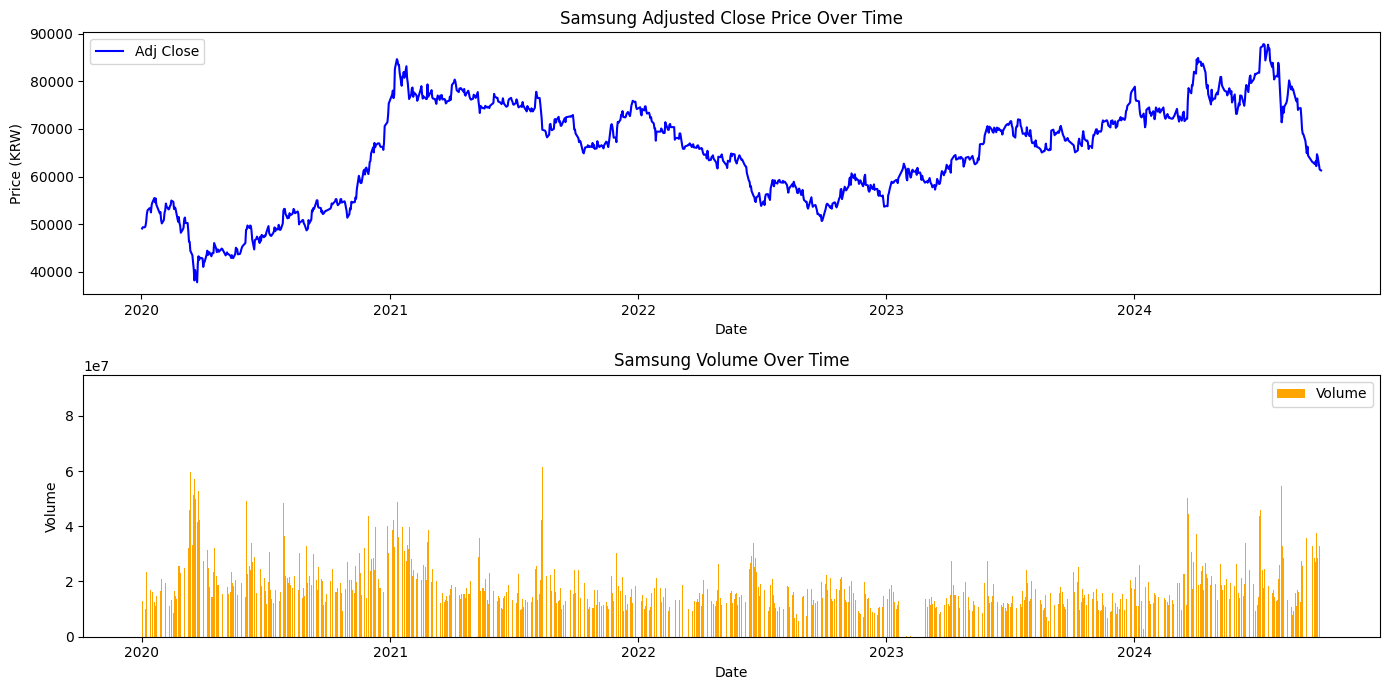

In [7]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(df.index, df['Adj Close'], color='blue', label='Adj Close')
plt.title('Samsung Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (KRW)')
plt.legend()

plt.subplot(2, 1, 2)
plt.bar(df.index, df['Volume'], color='orange', label='Volume')
plt.title('Samsung Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()

plt.tight_layout()
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

1) 2020년 초에는 약 50,000원에서 시작하여 2021년 초에 최고점인 약 85,000원을 기록

2) 2020년부터 2021년까지 상승세를 보였으나, 그 이후로 하락세를 보이고 있음

3) 특히 주가가 상승한 2021년 초와 하락한 시기에 거래량이 눈에 띄게 증가

4) 주가의 급등 또는 급락 시 거래량이 증가하는 경향을 보임

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

* 정상성 3가지 조건

1) 평균 일정

2) 분산 일정

3) 공분산이 시점 t에 의존하지 않고 시차인 h에 의존함

시계열 데이터가 비정상성을 띤다면 평균과 분산이 다르기 때문에 임의의 시점 t-1, t에서 얻은 모델은 t+1~t+n에서 사용할 수 없게 됩니다. 즉, 미래의 값을 예측할 수 없게 되는 것입니다.

* 비정상성 해결 방법

1) 차분: t시점과 t-1시점의 값의 차이

2) 로그 변환: 시계열 데이터 값에 로그를 취하는 것

3) 로그 차분: 로그 변환으로 지수적인 시계열 데이터를 선형적으로 바꿔주고 분산을 안정화 시킨 후 차분을 추가적으로 진행하여 정상성을 띠게하는 방법

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

* ADF Test: 시계열 데이터가 정상성을 가지는지 검정하는 방법

In [8]:
adf_result = adfuller(df['Adj Close'])

adf_statistic = adf_result[0]
p_value = adf_result[1]

print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")

ADF Statistic: -2.0061476405384746
p-value: 0.28388409559963934


2.3 ADF Test 결과를 해석하세요.

p-value는 약 0.2838로 0.05보다 크므로 귀무가설을 기각하지 못한다. 즉, 비정상성을 띠고 있다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

ACF는 전체적인 상관관계(직접 + 간접)를 나타내는 반면, PACF는 특정 시차에서의 직접적인 상관관계만을 나타냅니다.

**ACF 그래프**: 이동평균(Moving Average, MA) 모델의 적합한 차수를 결정하는 데 유용합니다.

**PACF 그래프**: 자기회귀(AutoRegressive, AR) 모델의 적합한 차수를 결정하는 데 사용됩니다.

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

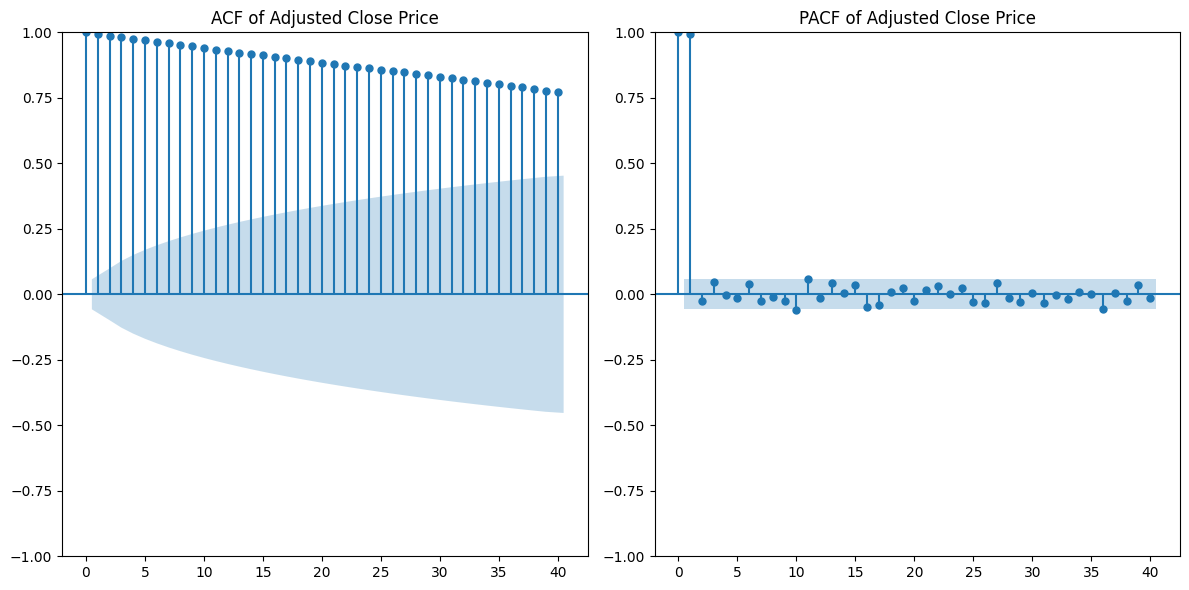

In [9]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(df['Adj Close'], ax=plt.gca(), lags=40)
plt.title('ACF of Adjusted Close Price')

plt.subplot(1, 2, 2)
plot_pacf(df['Adj Close'], ax=plt.gca(), lags=40)
plt.title('PACF of Adjusted Close Price')

plt.tight_layout()
plt.show()

2.6 결과를 해석하세요.

1) ACF(자기상관 함수) 그래프 해석: 차 시차부터 높은 상관관계를 보이고 있으며, 시차(lag)가 40까지도 유의미한 상관관계가 남아있는 것을 확인할 수 있음. 이는 시계열 데이터가 **비정상성(non-stationary)**일 가능성이 높다는 것을 의미함.

2) PACF(부분 자기상관 함수): 1차 시차에서 매우 높은 상관관계를 보이며, 그 이후에는 상관관계가 급격히 0에 가까워짐. 이는 시계열 데이터가 1차 자기회귀(AR(1)) 모델로 설명될 수 있음을 시사함.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

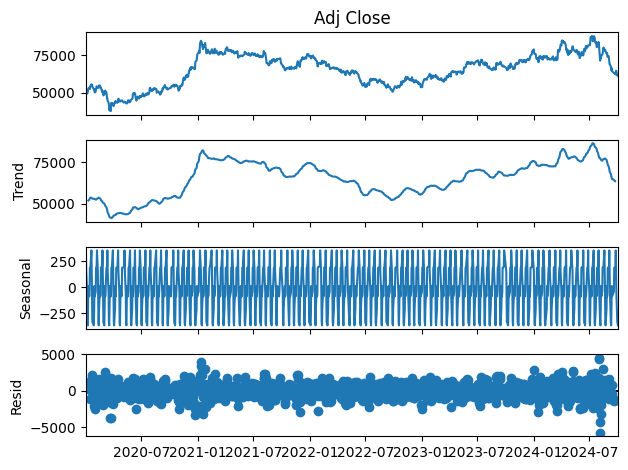

In [10]:
decomposition = seasonal_decompose(df['Adj Close'], period=12)

decomposition.plot()
plt.show()

2.8 위 결과를 해석하세요.

1) **Observed(원본 데이터)**: 삼성전자의 수정종가(Adjusted Close)를 보여줌. 2020년 중반부터 2021년 초까지 상승했다가 이후에 하락하는 추세를 보인다.

2) **Trend(추세)**: 장기적인 가격 변동 패턴을 보여주며, 주가가 2020년 중반부터 2021년 초까지 상승한 후, 2022년 이후에는 하락세가 이어지고 있음을 나타낸다.

3) **Seasonal(계절성)**: 일정 주기로 반복되는 패턴을 보여주며, 데이터에서 월별 주기(period=12)에 따른 계절성을 반영한 것

4) **Residual(잔차)**: 잔차는 추세와 계절성을 제거한 후 남은 부분으로, 주가의 비정상적인 움직임이나 예외적인 변동을 나타낸다. 잔차는 무작위로 분포되어 있으며, 특별한 패턴이 보이지 않습니다.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

차분은 시간에 따른 데이터의 변화를 계산하여 데이터를 정상성(stationary)으로 변환하는 방법이다. 일반적으로, 데이터의 값에서 이전 시점의 값을 빼서 새로운 시계열을 만든다.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [11]:
df_diff = df['Adj Close'].diff().dropna()

adf_result_diff = adfuller(df_diff)

adf_statistic_diff = adf_result_diff[0]
p_value_diff = adf_result_diff[1]

print(f"ADF Statistic after Differencing: {adf_statistic_diff}")
print(f"p-value after Differencing: {p_value_diff}")

ADF Statistic after Differencing: -25.005164955295765
p-value after Differencing: 0.0


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

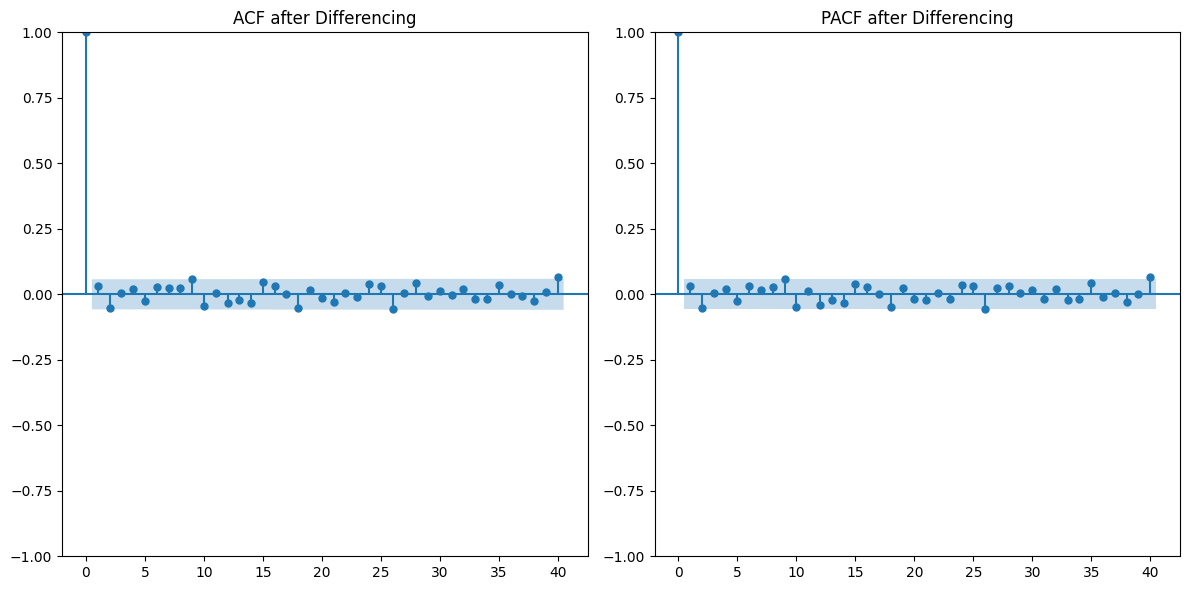

In [12]:
plt.figure(figsize=(12, 6))

# ACF 그래프
plt.subplot(1, 2, 1)
plot_acf(df_diff, ax=plt.gca(), lags=40)
plt.title('ACF after Differencing')

# PACF 그래프
plt.subplot(1, 2, 2)
plot_pacf(df_diff, ax=plt.gca(), lags=40)
plt.title('PACF after Differencing')

plt.tight_layout()
plt.show()

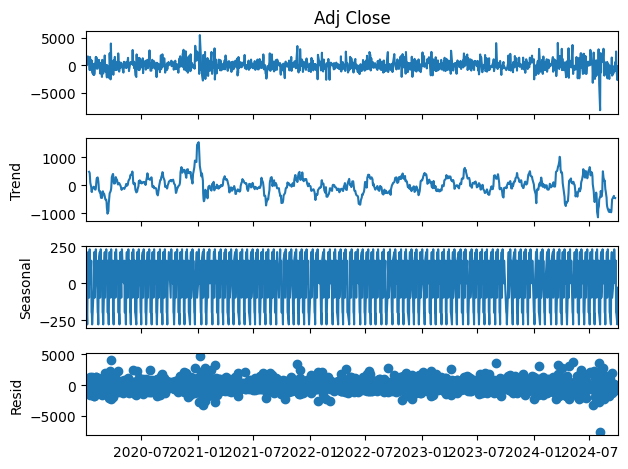

In [13]:
decomposition = seasonal_decompose(df_diff, period=12)

decomposition.plot()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

## ARIMA 모형

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

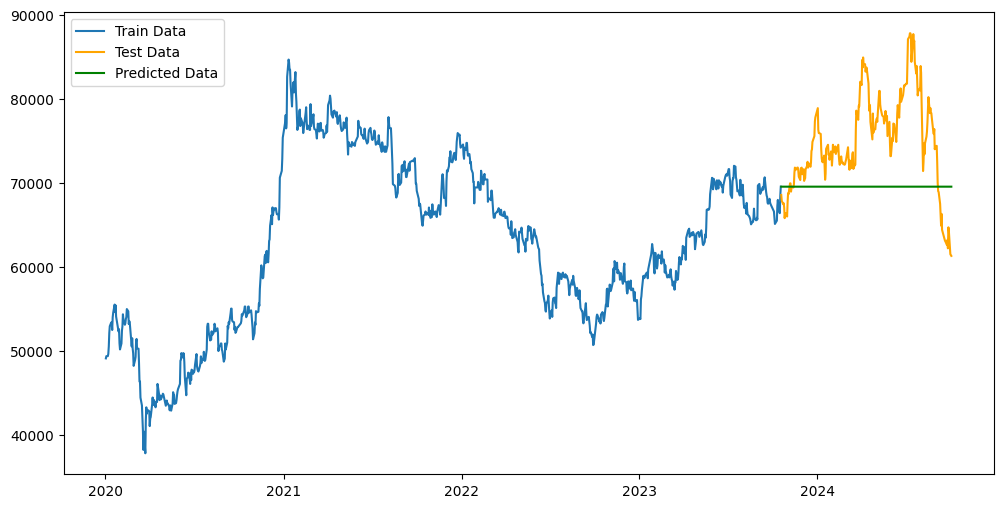

Mean Squared Error: 61917298.60837684


In [15]:
data = df['Adj Close']

# 학습 및 테스트 데이터 분리 (80% 학습, 20% 테스트)
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# ARIMA 모델 정의 (p, d, q 설정)
# 여기서 p: AR 차수, d: 차분의 횟수, q: MA 차수
model = ARIMA(train_data, order=(1, 1, 1))

# ARIMA 모델 학습
fitted_model = model.fit()

# 테스트 데이터에 대해 예측 수행
predictions = fitted_model.forecast(steps=len(test_data))

# 예측 결과와 실제 결과 비교
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.plot(test_data.index, predictions, label='Predicted Data', color='green')
plt.legend()
plt.show()

# 모델 평가 (평균 제곱 오차)
mse = mean_squared_error(test_data, predictions)
print(f"Mean Squared Error: {mse}")

## LSTM 모델

In [16]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.1305
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0158
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0086
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0064
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0050
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0053
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0042
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0047
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0042
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0042
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Train MSE: 4700862.628781347
Test MSE: 10606509.938371023


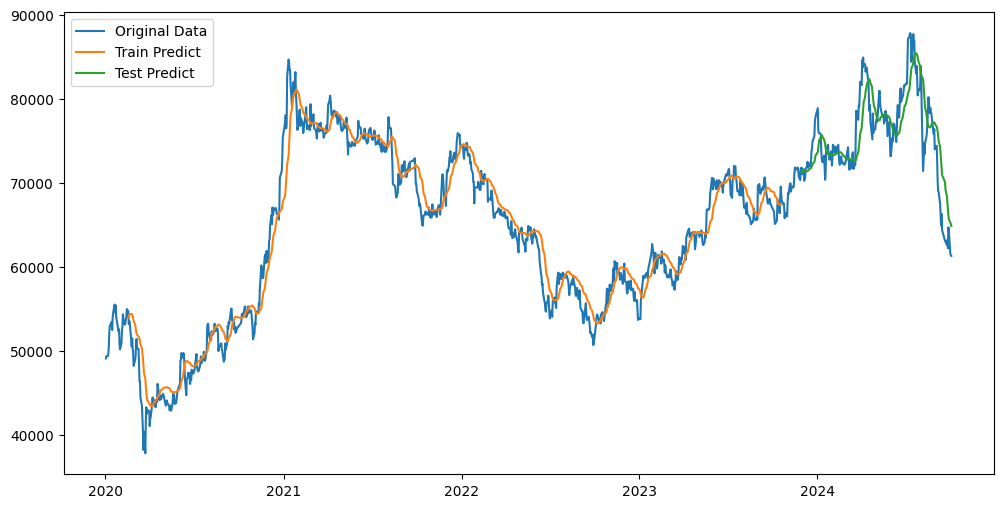

In [17]:
# 'Adj Close' 종가 데이터만 사용
data = df['Adj Close'].values.reshape(-1, 1)

# 데이터 정규화 (0과 1 사이 값으로 변환)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 학습 및 테스트 데이터 분리 (80% 학습, 20% 테스트)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# 시계열 데이터 생성 함수
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# 시계열 데이터 생성 (30일 단위 예측)
time_step = 30
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# 데이터를 LSTM 입력 형태로 변환 (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1)

# 예측 수행
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 원래 스케일로 복구
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train_inv = scaler.inverse_transform([Y_train])
Y_test_inv = scaler.inverse_transform([Y_test])

# MSE 계산
train_mse = mean_squared_error(Y_train_inv[0], train_predict)
test_mse = mean_squared_error(Y_test_inv[0], test_predict)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, data, label='Original Data')
plt.plot(df.index[time_step:train_size], train_predict, label='Train Predict')
plt.plot(df.index[train_size + time_step:], test_predict, label='Test Predict')
plt.legend()
plt.show()

### Prophet

Prophet 모델: 특히 비즈니스 예측(매출, 주식 가격, 트래픽 등)에 자주 사용. 데이터에서 자동으로 추세와 계절성을 추출하여 처리함

In [19]:
!pip install prophet

In [21]:
from prophet import Prophet

In [24]:
df2 = pd.read_csv("/content/gdrive/MyDrive/DAT/4기 과제/4차 과제/samsung_stock_data.csv")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o_6__si/205m9ler.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o_6__si/syrar0c1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99995', 'data', 'file=/tmp/tmp6o_6__si/205m9ler.json', 'init=/tmp/tmp6o_6__si/syrar0c1.json', 'output', 'file=/tmp/tmp6o_6__si/prophet_modeltadxdyf5/prophet_model-20241006165443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:54:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:54:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error: 7524746.779464324


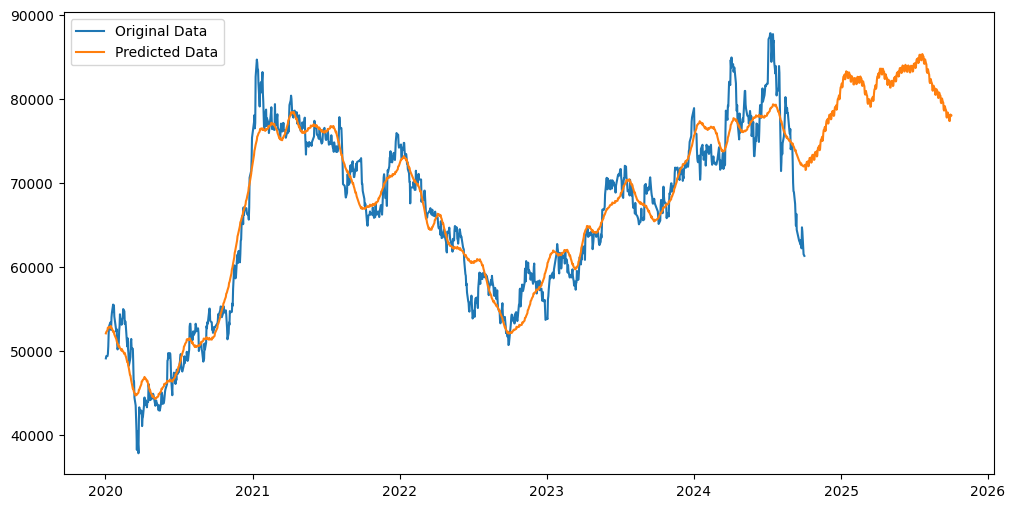

In [29]:
# 'Date' 열을 datetime 형식으로 변환하면서 타임존 제거 (tz_localize(None) 사용)
df2['Date'] = pd.to_datetime(df2['Date']).dt.tz_localize(None)

# Prophet에 맞게 데이터 프레임 구성
# 'Date' 열을 'ds', 'Adj Close' 열을 'y'로 변경 (Prophet의 요구 사항)
df_prophet = df2[['Date', 'Adj Close']].rename(columns={'Date': 'ds', 'Adj Close': 'y'})

# Prophet 모델 생성
model = Prophet()

# 모델 학습
model.fit(df_prophet)

# 미래 날짜 생성 (365일 예측)
future = model.make_future_dataframe(periods=365)

# 예측 수행
forecast = model.predict(future)

# 예측 결과와 실제 값 비교 (MSE 계산)
# 실제 값과 예측 값의 기간이 일치하는 부분만 비교
actual = df_prophet['y']  # 실제 값
predicted = forecast['yhat'][:len(actual)]  # 예측 값 (실제 값과 같은 기간만)

# MSE 계산
mse = mean_squared_error(actual, predicted)
print(f"Mean Squared Error: {mse}")

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Original Data')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Data')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

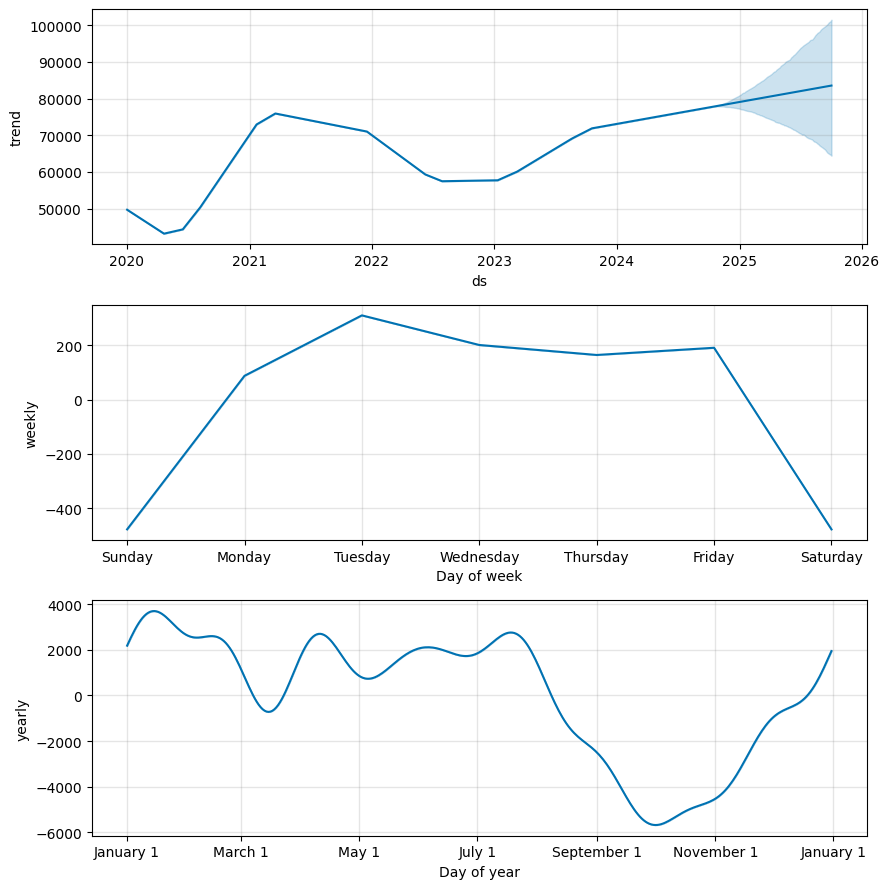

In [28]:
# 트렌드, 주기성 확인
model.plot_components(forecast)
plt.show()